# Setup

In [19]:
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

#Libraries for NLP
import nltk
nltk.download('wordnet')

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
import pandas as pd 
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

[nltk_data] Downloading package wordnet to C:\Users\Oshadha
[nltk_data]     Abeyrathne\AppData\Roaming\nltk_data...


Loading BokehJS ...

# Exploratory Analysis

In [44]:
#reading in the files
df_test = pd.read_csv('test.csv')
df_train = pd.read_csv('train.csv')

df_test.head(10)

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...
5,20978,Pairwise Difference Estimation of High Dimensi...,This paper proposes a regularized pairwise d...
6,20979,Dissecting the multivariate extremal index and...,A central issue in the theory of extreme val...
7,20980,"Big Universe, Big Data: Machine Learning and I...",Astrophysics and cosmology are rich with dat...
8,20981,Natural Language Does Not Emerge 'Naturally' i...,A number of recent works have proposed techn...
9,20982,Properties and Origin of Galaxy Velocity Bias ...,We use the hydrodynamical galaxy formation s...


In [11]:
df_train.head(15)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0
5,6,On maximizing the fundamental frequency of the...,Let $\Omega \subset \mathbb{R}^n$ be a bound...,0,0,1,0,0,0
6,7,On the rotation period and shape of the hyperb...,We observed the newly discovered hyperbolic ...,0,1,0,0,0,0
7,8,Adverse effects of polymer coating on heat tra...,The ability of metallic nanoparticles to sup...,0,1,0,0,0,0
8,9,SPH calculations of Mars-scale collisions: the...,We model large-scale ($\approx$2000km) impac...,0,1,0,0,0,0
9,10,$\mathcal{R}_{0}$ fails to predict the outbrea...,Time varying susceptibility of host at indiv...,0,0,0,0,1,0


In [12]:
#Getting abstracts from the test and train data
train_text = df_train["ABSTRACT"]
test_text = df_test["ABSTRACT"]

In [13]:
#Function to get top words and counts
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

C:\Users\Oshadha Abeyrathne\AppData\Local\Temp\ipykernel_9724\1234236920.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(words, rotation='vertical');


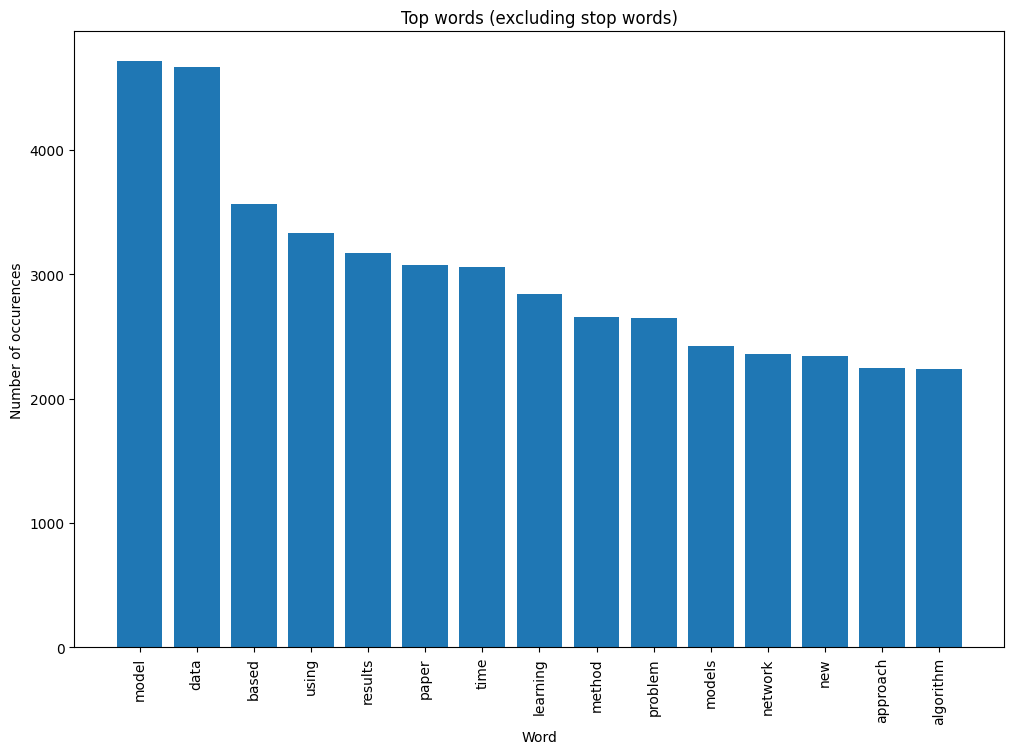

range(0, 15)


In [14]:
#Removing stop words and developing a list of top words in abstracts
cv = CountVectorizer(stop_words='english')
words, word_val = get_top_n_words(n_top_words=15, count_vectorizer=cv, text_data=test_text)
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(words, word_val)
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()
print(range(len(words)))

# Topic Modeling

## Preprocessing for LDA

In [20]:
#Making a class for both tokenization and lemmatization
lemm = nltk.WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [21]:
# Storing all training text in a list
text = list(train_text)

# Calling the overwritten count vectorizer
tf_vectorizer = LemmaCountVectorizer(max_df=0.95, min_df=2, stop_words='english', 
                                     decode_error='ignore')
tf = tf_vectorizer.fit_transform(text)

## LDA (Sklearn)

In [22]:
#number of topics
n_topics=10

In [23]:
#Creating an LDA instance
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', 
                                learning_offset=50., random_state=0, verbose =0)
lda.fit(tf)

#Making an LDA topic matrix of the corpus
lda_topic_matrix = lda.fit_transform(tf)

In [24]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [25]:
# Getting the categories and counts from the lda model
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [26]:
# Function to get top words from each category
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [27]:
# Printing words from each topic
top_n_words = get_top_n_words(20, lda_keys, tf, tf_vectorizer)

for i in range(len(top_n_words)):
    print("Topic {}:\n ".format(i), top_n_words[i] + "\n")

Topic 0:
  energy power paper model market price cost resource system network based high technology time data result user performance computing design

Topic 1:
  result problem function space graph paper equation time mathbb set group prove solution case number study theory model class algebra

Topic 2:
  network training neural learning adversarial deep model image method gan generative result trained data performance task using propose end input

Topic 3:
  language paper logic problem program model result based present theory analysis used work algorithm proof code system type semantics software

Topic 4:
  cell mutation model tumor game gene tree cause time cop pathway dna protein player population effect specie sequence result phylogeny

Topic 5:
  model data network method learning based approach algorithm problem result time paper using task performance proposed information state feature propose

Topic 6:
  star galaxy mass model data using observation 10 result stellar planet 

In [28]:
#Transforming the LDA topic matrix to 2 dimensions for plotting
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 20972 samples in 0.027s...
[t-SNE] Computed neighbors for 20972 samples in 1.971s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20972
[t-SNE] Computed conditional probabilities for sample 2000 / 20972
[t-SNE] Computed conditional probabilities for sample 3000 / 20972
[t-SNE] Computed conditional probabilities for sample 4000 / 20972
[t-SNE] Computed conditional probabilities for sample 5000 / 20972
[t-SNE] Computed conditional probabilities for sample 6000 / 20972
[t-SNE] Computed conditional probabilities for sample 7000 / 20972
[t-SNE] Computed conditional probabilities for sample 8000 / 20972
[t-SNE] Computed conditional probabilities for sample 9000 / 20972
[t-SNE] Computed conditional probabilities for sample 10000 / 20972
[t-SNE] Computed conditional probabilities for sample 11000 / 20972
[t-SNE] Computed conditional probabilities for sample 12000 / 20972
[t-SNE] Computed conditional probabilities for sa

In [29]:
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [32]:
# Colourmap for the visualization
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [35]:
#Top 3 word from each topic to use in plot
top_3_words_lda = get_top_n_words(3, lda_keys, tf, tf_vectorizer)

#Getting the mean of the topic vector for the visualization
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

#Creating the t-SNE plot
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), width=600, height=600)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [36]:
doc_topic = lda.transform(tf)

for n in range(20):
    topic_most_pr = doc_topic[n].argmax()
    print("Document #{} - topic: {}\n".format(n,topic_most_pr))

Document #0 - topic: 5

Document #1 - topic: 2

Document #2 - topic: 1

Document #3 - topic: 1

Document #4 - topic: 5

Document #5 - topic: 7

Document #6 - topic: 6

Document #7 - topic: 9

Document #8 - topic: 9

Document #9 - topic: 5

Document #10 - topic: 0

Document #11 - topic: 9

Document #12 - topic: 9

Document #13 - topic: 1

Document #14 - topic: 9

Document #15 - topic: 1

Document #16 - topic: 6

Document #17 - topic: 1

Document #18 - topic: 5

Document #19 - topic: 9



## Advanced Analysis of LDA

My main goal is to
1. Find the most relevant articles for each topic so they can be used as the links for further research
2. maybe find another way to list the most relevant articles such as using rating or views (later)

In [37]:
# making a dataframe from the document-topic matrix
doc_topic_df = pd.DataFrame(data=doc_topic)
doc_topic_df

,0,1,2,3,4,5,6,7,8,9
0,0.000559,0.000559,0.046680,0.155668,0.020155,0.516730,0.000559,0.000559,0.219046,0.039486
1,0.002222,0.002223,0.469878,0.002223,0.002222,0.215080,0.002223,0.002224,0.299482,0.002223
2,0.001923,0.689229,0.001923,0.001923,0.001923,0.001923,0.001923,0.001923,0.295386,0.001923
3,0.001588,0.571966,0.001588,0.001588,0.001587,0.001588,0.001588,0.001587,0.230501,0.186420
4,0.001235,0.001235,0.112500,0.001235,0.011195,0.525566,0.163221,0.015370,0.167209,0.001235
...,...,...,...,...,...,...,...,...,...,...
20967,0.000855,0.024481,0.142635,0.100983,0.000855,0.695277,0.000855,0.000855,0.000855,0.032350
20968,0.039384,0.001220,0.001220,0.001220,0.001220,0.001220,0.001220,0.013319,0.037031,0.902948
20969,0.000926,0.052783,0.079925,0.013801,0.070857,0.742548,0.036381,0.000926,0.000926,0.000926
20970,0.016090,0.092410,0.000870,0.000870,0.010376,0.094989,0.037799,0.043247,0.702479,0.000870


5    7861
1    4880
9    3639
8    2369
6    1183
3     459
0     235
7     180
2     148
4      18
Name: count, dtype: int64

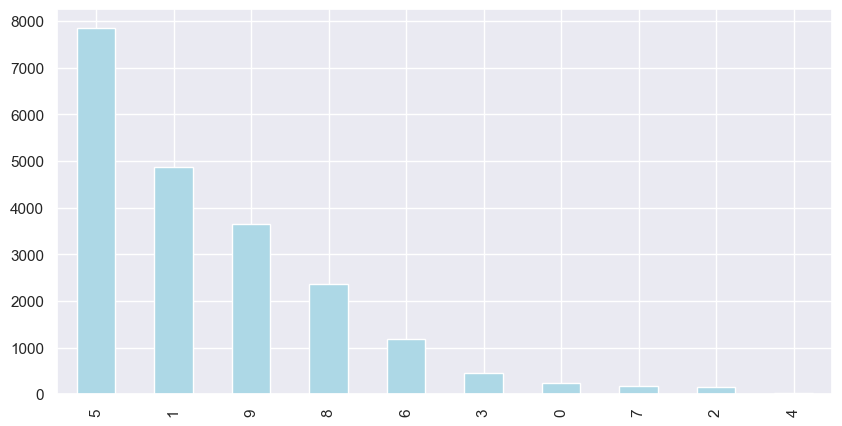

In [39]:
#plotting the distribution of documents over each topic
sns.set(rc={'figure.figsize':(10,5)})
doc_topic_df.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#store the distributions in a dataframe
distribution = doc_topic_df.idxmax(axis=1).value_counts()
distribution